<a href="https://colab.research.google.com/github/sankalpachowdhury/Fractal_Analysis/blob/master/Higuchi_Fractal_analysis_with_log_log_without_logspace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#C codes

In [ ]:
#include <stdio.h>

int main()
{
   int i, j, k, m, n, s=0, l, x=0;
   printf("Enter sample size:");
   scanf("%d",&n);
   printf("Enter largest time delay parameter:");
   scanf("%d",&k);
   int a[n];
   for(i=2;i<=k;i++)
   {
       for(m=0;m<i;m++)
       {
            for(j=m;j<n;j=j+i)
                s=s+a[j+i]-a[j];
            l=(s*(n-1))/(j*i);
            s=0;
            x=x+l;
       }
       printf("The average is %d for k= %d",x/i,i);
       x=0;
   }
}

In [ ]:
#include <stdio.h>

int main()
{
      int n, k, i=0, b=0, s=0, l=0, m;
    printf("Enter sample size:");
    scanf("%d",&n);
    printf("\nEnter the time delay parameter:");
    scanf("%d",&b);
    int a[n];
    while(i<n)
        {
            scanf("%d",&a[i]);
            i++;
        }
    for(k=2;k<=b;k++)
    {
        for(m=0;m<k;m++)
        {
            for(i=m;i<n;i=i+k)
                s=s+a[i+k]-a[i];
            l=l+((s*(n-1))/((i+k)*k));
            s=0;
        }
        printf("\nAvg length %d for %d",l/k,k);
        l=0;
    }

}

In [ ]:
#!git clone https://github.com/inuritdino/HiguchiFractalDimension.git

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [94]:
import os
import ctypes
import numpy as np
from numpy.ctypeslib import ndpointer

def curve_length(X,opt=False,num_k=50,k_max=None):
    """
    Calculate curve length <Lk> for Higuchi Fractal Dimension (HFD)
    
    Input:
    
    X - input (time) series (must be 1D, to be converted into a NumPy array)
    opt (=True) - optimized? (if libhfd.so was compiled uses the faster code).
    num_k - number of k values to generate.
    k_max - the maximum k (the k array is generated uniformly in log space 
            from 2 to k_max)
    Output:
    k - interval "times", window sizes
    Lk - curve length
    """
    ### Make sure X is a NumPy array with the correct dimension
    X = np.array(X)
    if X.ndim != 1:
        raise ValueError("Input array must be 1D (time series).")
    N = X.size

    ### Get interval "time"
    k_arr = interval_t(N,num_val=num_k,kmax=k_max)

    ### The average length
    Lk = np.empty(k_arr.size,dtype=np.float)

    ### C library
    '''
    if opt:
        X = np.require(X, float, ('C', 'A'))
        k_arr = np.require(k_arr, ctypes.c_size_t, ('C', 'A'))
        Lk = np.require(Lk, float, ('C', 'A'))
        ## Load library here
        libhfd = init_lib()
        ## Run the C code here
        libhfd.curve_length(k_arr,k_arr.size,X,N,Lk)
    '''
    #else:
        ### Native Python run
    for i in range(k_arr.size):# over array of k's
            Lmk = 0.0
            for j in range(k_arr[i]):# over m's
                ## Construct X_k^m, i.e. X_(k_arr[i])^j, as X[j::k_arr[i]]
                ## Calculate L_m(k)
                Lmk += (
                    np.sum(
                        np.abs(
                            np.diff( X[j::k_arr[i]] )
                        )
                    )
                    * (N - 1) /
                    (
                        ( (N-j-1)//k_arr[i] )
                        *
                        k_arr[i]
                    )
                ) / k_arr[i]

            ### Calculate the average Lmk
            Lk[i] = Lmk / k_arr[i]

    return (k_arr, Lk);

def lin_fit_hfd(k,L,log=True):
    """
    Calculate Higuchi Fractal Dimension (HFD) by fitting a line to already computed
    interval times k and curve lengths L
    Input:
    k - interval "times", window sizes
    L - curve length
    log (=True) - k and L values will be transformed to np.log2(k) and np.log2(L),
                  respectively
    Output:
    HFD
    """
    if log:
        return (-np.polyfit(np.log2(k),np.log2(L),deg=1)[0]);
    else:
        return (-np.polyfit(k,L,deg=1)[0]);

def hfd(X,**kwargs):
    """
    Calculate Higuchi Fractal Dimension (HFD) for 1D data/series
    Input:
    X - input (time) series (must be 1D, to be converted into a NumPy array)
    Output:
    
    HFD
    """
    k, L = curve_length(X,**kwargs)
    return lin_fit_hfd(k, L);

# Generating th interval
def interval_t(size,num_val=50,kmax=None):
    list_space = []
    ### Generate sequence of interval times, k
    if kmax is None:
        k_stop = size//2
    else:
        k_stop = kmax
    if k_stop > size//2:   ## prohibit going larger than N/2
        k_stop = size//2
        print("Warning: k cannot be longer than N/2")
    
    for i in range(2, k_stop):
      list_space.append(i)    
    
    #k = np.logspace(start=np.log2(2),stop=np.log2(k_stop),base=2,num=num_val,dtype=np.int)
    return np.unique(list_space);

def init_lib():
    libdir = os.path.dirname(__file__)
    libfile = os.path.join(libdir, "libhfd.so")
    lib = ctypes.CDLL(libfile)

    rwptr = ndpointer(float, flags=('C','A','W'))
    rwptr_sizet = ndpointer(ctypes.c_size_t, flags=('C','A','W'))

    lib.curve_length.restype = ctypes.c_int
    lib.curve_length.argtypes = [rwptr_sizet, ctypes.c_size_t, rwptr, ctypes.c_size_t, rwptr]

    return lib;

In [ ]:
x = np.random.randn(1000)
y = np.empty(990)
for i in range(x.size-10):
	y[i] = np.sum(x[:(i+10)])
 
for i in x:
  print(i)



In [ ]:
for j in y:
  print(i)

In [96]:
# Validation of the algorithm
x = np.random.randn(1000)
y = np.empty(990)
for i in range(x.size-10):
	y[i] = np.sum(x[:(i+10)])
	
## Note x is a Guassian noise, y is the original Brownian data used in Higuchi, Physica D, 1988.

print(hfd(x)) # ~ 2.00
print(hfd(y)) # ~ 1.50
#print(a, b)

1.9975727445389577
1.4775746645268746


In [ ]:
k, l = curve_length((x))
print(k, l)

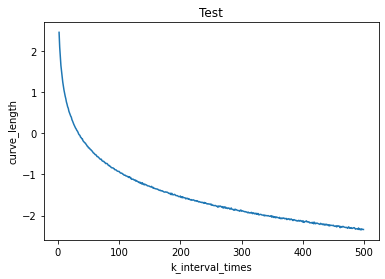

In [97]:
import math
#x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in l:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Test") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(k,y) 
plt.show()

Raw fit results:
poly([-0.21253377 -0.00507387])
[array([71.2578201]), 2, array([1.36649965, 0.36425087]), 1.1057821325266559e-13]
Fit: A = -0.005[P] + -0.213 (rms residual = 0.3783)


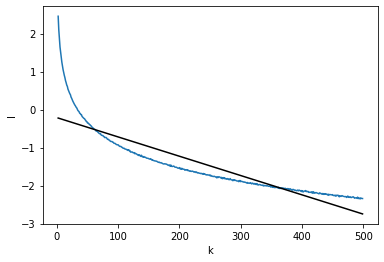

In [98]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k
A = y

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

In [ ]:
# Linear Regression

import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
y = np.array([5, 20, 14, 32, 22, 38])

In [ ]:
model = LinearRegression()
model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
model = LinearRegression().fit(x, y)

In [ ]:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.7158756137479542


In [ ]:
print('intercept:', model.intercept_)

intercept: 5.633333333333329


In [ ]:
print('slope:', model.coef_)

slope: [0.54]


In [ ]:
new_model = LinearRegression().fit(x, y.reshape((-1, 1)))
print('intercept:', new_model.intercept_)
print('slope:', new_model.coef_)

intercept: [5.63333333]
slope: [[0.54]]


In [ ]:
y_pred = model.predict(x)
print('predicted response:', y_pred, sep='\n')

predicted response:
[ 8.33333333 13.73333333 19.13333333 24.53333333 29.93333333 35.33333333]


In [ ]:
y_pred = model.intercept_ + model.coef_ * x
print('predicted response:', y_pred, sep='\n')

predicted response:
[[ 8.33333333]
 [13.73333333]
 [19.13333333]
 [24.53333333]
 [29.93333333]
 [35.33333333]]


In [ ]:
x_new = np.arange(5).reshape((-1, 1))
print(x_new)

[[0]
 [1]
 [2]
 [3]
 [4]]


Estimated coefficients:
b_0 = 182.8376262481708  nb_1 = -0.06738456743257776


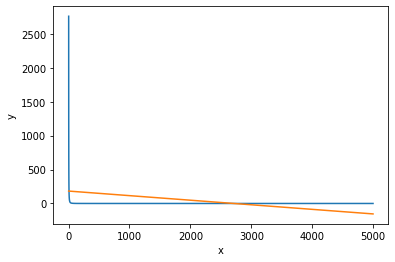

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
  
def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
  
def plot_regression_line(x, y, b): 
    # plotting the actual points as scatter plot 
    #plt.scatter(x, y, color = "m", marker = "o", s = 30) 
    plt.plot(x, y)
  
    # predicted response vector 
    y_pred = b[0] + b[1]*x 
  
    # plotting the regression line 
    #plt.plot(x, y_pred, color = "g") 
    plt.plot(x, y_pred)
  
    # putting labels 
    plt.xlabel('x') 
    plt.ylabel('y') 
  
    # function to show plot 
    plt.show() 
  
def main(): 
    # observations 
    x = k  # np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) 
    y = l  # np.array([1, 3, 2, 5, 7, 8, 8, 9, 10, 12]) 
  
    # estimating coefficients 
    b = estimate_coef(x, y) 
    print("Estimated coefficients:\nb_0 = {}  nb_1 = {}".format(b[0], b[1])) 
  
    # plotting regression line 
    plot_regression_line(x, y, b) 
  
if __name__ == "__main__": 
    main()

#Data Preprocessing

In [99]:
data = pd.read_csv('/content/AVG_DATA.csv')
data.head()

,DATE,SNO.,MAHARASHTRA,ANDHRA PRADESH,TAMIL NADU,KARNATAKA,UTTAR PRADESH,DELHI,WEST BENGAL
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/04/2020,1.0,33.0,67.0,110.0,9.0,13.0,32.0,37.0
2,02/04/2020,2.0,62.0,40.0,96.0,9.0,23.0,89.0,18.0
3,03/04/2020,3.0,89.0,42.0,89.0,10.0,35.0,77.0,16.0
4,04/04/2020,4.0,107.0,38.0,77.0,11.0,38.0,75.0,9.0


In [ ]:
maha = data.MAHARASHTRA
print(maha[1:154])

andhra = data['ANDHRA PRADESH']
print(andhra[1:154])

tamil = data['TAMIL NADU']
print(tamil[1:154])

karna = data.KARNATAKA
print(karna[1:154])

up = data['UTTAR PRADESH']
print(up[1:154])

delhi = data['DELHI']
print(delhi[1:154])

wb = data['WEST BENGAL']
print(wb[1:154])

In [101]:
import pandas
print(pandas.__version__)

1.0.5


In [102]:
# convert dataframe to np.array
import numpy
maha_np_array = data['MAHARASHTRA'].to_numpy()
#maha_np_array = list(numpy.concatenate().flat)) 
print(maha_np_array[1:154])

andhra_np_array = andhra.to_numpy()
print(andhra_np_array[1:154])

tamil_np_array = tamil.to_numpy()
print(tamil_np_array[1:154])

karna_np_array = karna.to_numpy()
print(karna_np_array[1:154])

up_np_array = up.to_numpy()
print(up_np_array[1:154])

delhi_np_array = delhi.to_numpy()
print(delhi_np_array[1:154])

wb_np_array = wb.to_numpy()
print(wb_np_array[1:154])

[   33.    62.    89.   107.   119.   130.   146.   165.   179.   193.
   240.   263.   268.   288.   268.   263.   304.   350.   403.   466.
   556.   523.   592.   570.   588.   578.   620.   574.   688.   741.
   731.   925.  1005.  1050.  1136.  1218.  1137.  1329.  1329.  1291.
  1372.  1459.  1386.  1461.  1725.  1827.  1922.  2039.  2187.  2306.
  2426.  2619.  2674.  2623.  2473.  2471.  2399.  2500.  2579.  2613.
  2551.  2526.  2525.  2515.  2591.  2735.  2734.  2599.  2762.  2936.
  3033.  3208.  3434.  3341.  3159.  3122.  3187.  3275.  3492.  3726.
  3809.  3701.  3714.  3907.  4138.  4667.  5123.  5397.  5404.  5507.
  5499.  5673.  6036.  6372.  6338.  6099.  6147.  6107.  6368.  6923.
  7461.  7080.  7053.  7076.  7176.  7272.  8003.  8558.  8611.  8550.
  9004.  9313.  9332.  9535.  9754.  9223.  8788.  8707.  9086.  9264.
  9599.  9958.  9909.  9232.  9229.  9612.  9807. 10578. 11475. 11250.
 11164. 11610. 11408. 11480. 12048. 12053. 11209. 11070. 11182. 11707.
 12317

#MAHARASHTRA



In [161]:
# inputs to Higuchi Algorithm

# k_value = int(input("Enter the bound og 'k' "))
data_list = maha_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 75
Max. k value: 14
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75] [13612.54333333  7888.57481481  5054.38344595  3503.97108966
  2598.36493827  2107.39675135  1800.515625    1623.8484225
  1471.8232381   1333.35425456  1203.46061308  1101.10845368
  1017.75066408   947.52771687   885.33794488   833.17687767
   789.75614834   750.01385042   712.41811905   679.25197834
   650.8401703    623.87003096   599.52806713   577.0639872
   555.85464269   535.39090586   514.9976312    496.51785641
   479.19463704   464.05214103   450.07177734   437.73577835
   425.39683832   412.37319339   400.98812586   389.29925835
   380.22645429   371.67855156   363.64614583   356.31191267
   348.43317856   341.54929755   334.72927623   327.96554184
   320.99047971   313.77532917   307.13505498

In [162]:
hfd(data_list)

1.07049676773535

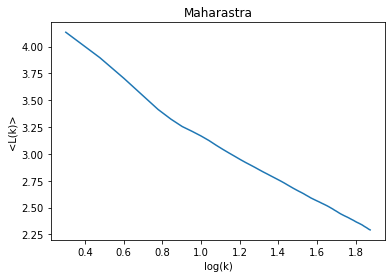

In [163]:
import math
#x = k_interval_times
log_x = []
for i in k_interval_times:
  log_x.append(math.log10(i))
  #log_x.append(int(i))
x = log_x
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
  #log_y.append(int(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Maharastra") 
plt.xlabel("log(k)") 
plt.ylabel("<L(k)>") 
plt.plot(x,y) 
plt.show()

In [164]:
plt.savefig('maha1.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([ 4.27747729 -1.07049677])
[array([0.09368093]), 2, array([1.40423584, 0.1676953 ]), 1.6431300764452317e-14]
Fit: A = -1.070[P] + 4.277 (rms residual = 0.0356)


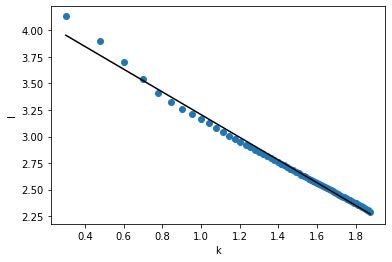

In [165]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
#conc = k_interval_times

conc = log_x #np.array(log_x, dtype=np.int)
#A = curve_length_list



A = log_y #np.array(log_y, dtype=np.int)
#np.array(data, dtype=np.float32)
#int_array = float_array.astype(int)


cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

#res = [element * pfit for element in conc]
pylab.scatter(conc, A)
pylab.plot(conc, pfit(np.array(conc, dtype=np.float32)), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

In [166]:
plt.savefig('maha2.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
  
def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
  
def plot_regression_line(x, y, b): 
    # plotting the actual points as scatter plot 
    #plt.scatter(x, y, color = "m", marker = "o", s = 30) 
    plt.plot(x, y)
  
    # predicted response vector 
    y_pred = b[0] + b[1]*x 
  
    # plotting the regression line 
    #plt.plot(x, y_pred, color = "g") 
    plt.plot(x, y_pred)
  
    # putting labels 
    plt.xlabel('x') 
    plt.ylabel('y') 
  
    # function to show plot 
    plt.show() 
  
def main(): 
    # observations 
    x = log_x #k_interval_times #k  # np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) 
    y = log_y #curve_length_list #l  # np.array([1, 3, 2, 5, 7, 8, 8, 9, 10, 12]) 
  
    # estimating coefficients 
    b = estimate_coef(x, y) 
    print("Estimated coefficients:\nb_0 = {}  nb_1 = {}".format(b[0], b[1])) 
  
    # plotting regression line 
    plot_regression_line(x, y, b) 
  
if __name__ == "__main__": 
    main()

#ANDHRA PRADESH

In [167]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = andhra_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 75
Max. k value: 14
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75] [8185.28333333 5059.46074074 3575.2652027  2700.39496092 2167.25141975
 1812.32936277 1560.53819444 1360.75445816 1207.6248     1086.39195515
  990.17774972  909.48291472  832.86903142  770.00823045  718.59933811
  669.66008549  625.96585342  583.17728532  545.05480952  520.20575789
  501.82031054  485.6042081   468.50686728  451.9998464   440.08782431
  429.32489966  415.79187318  402.70402231  390.64872593  381.3359292
  376.21484375  370.13757409  361.64970486  351.42902235  341.56615798
  331.66221152  322.72045245  316.6109341   311.59960417  306.57850776
  300.24657164  293.81817115  286.37753569  278.37086786  269.89359196
  261.37354279  253.37227527  245.61569867  238.66209067  231.78421572
  222

In [168]:
hfd(data_list)

1.063517123545483

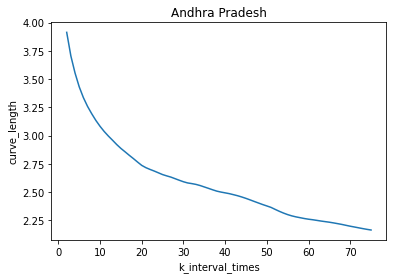

In [169]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Andhra Pradesh") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

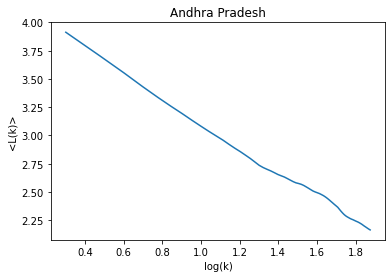

In [170]:
import math
#x = k_interval_times
log_x = []
for i in k_interval_times:
  log_x.append(math.log10(i))
  #log_x.append(int(i))
x = log_x
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
  #log_y.append(int(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Andhra Pradesh") 
plt.xlabel("log(k)") 
plt.ylabel("<L(k)>") 
plt.plot(x,y) 
plt.show()

In [171]:
plt.savefig('andhra1.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([ 4.16486424 -1.06351712])
[array([0.04195092]), 2, array([1.40423584, 0.1676953 ]), 1.6431300764452317e-14]
Fit: A = -1.064[P] + 4.165 (rms residual = 0.0238)


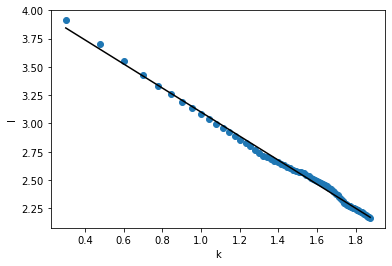

In [172]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
#conc = k_interval_times

conc = log_x #np.array(log_x, dtype=np.int)
#A = curve_length_list



A = log_y #np.array(log_y, dtype=np.int)
#np.array(data, dtype=np.float32)
#int_array = float_array.astype(int)


cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

#res = [element * pfit for element in conc]
pylab.scatter(conc, A)
pylab.plot(conc, pfit(np.array(conc, dtype=np.float32)), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

In [173]:
plt.savefig('andhra2.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([1904.68418221  -31.73570958])
[array([68974053.40679392]), 2, array([1.36910029, 0.35435068]), 1.6431300764452317e-14]
Fit: A = -31.736[P] + 1904.684 (rms residual = 965.4438)


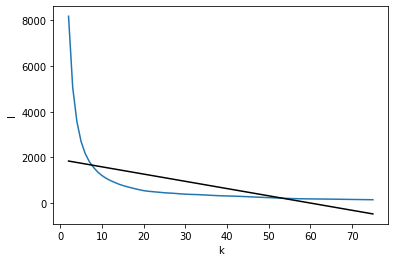

In [174]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

#TAMIL NADU

In [175]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = tamil_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 75
Max. k value: 14
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75] [5319.52666667 3438.69037037 2481.16891892 1923.28849655 1550.7412963
 1281.62399    1087.453125    931.3388203   812.58114286  719.82141825
  650.0316358   592.48300575  539.58953677  499.30110947  461.50146484
  434.91553023  412.53605722  390.13296399  376.12128571  356.75384228
  338.6277736   325.92404592  315.17716049  301.08581547  289.15457442
  279.44315399  269.43232507  260.48876133  252.47453333  244.87514126
  239.64190674  234.4265613   228.63745844  222.49225267  216.28355053
  210.28522167  204.58679594  203.11807909  201.7146875   199.32949319
  195.93771371  192.18405088  188.45532807  184.58096022  180.60931207
  176.52470069  172.4113016   168.30477097  164.23883733  160.16714537
  158

In [176]:
hfd(data_list)

1.0054068791382214

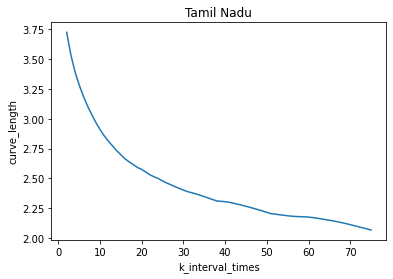

In [177]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Tamil Nadu") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

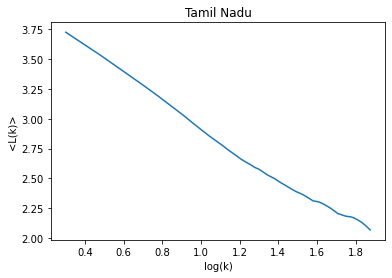

In [178]:
import math
#x = k_interval_times
log_x = []
for i in k_interval_times:
  log_x.append(math.log10(i))
  #log_x.append(int(i))
x = log_x
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
  #log_y.append(int(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Tamil Nadu") 
plt.xlabel("log(k)") 
plt.ylabel("<L(k)>") 
plt.plot(x,y) 
plt.show()

In [179]:
plt.savefig('tamil1.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([ 3.92691955 -1.00540688])
[array([0.10272135]), 2, array([1.40423584, 0.1676953 ]), 1.6431300764452317e-14]
Fit: A = -1.005[P] + 3.927 (rms residual = 0.0373)


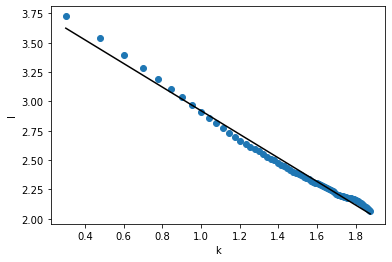

In [180]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
#conc = k_interval_times

conc = log_x #np.array(log_x, dtype=np.int)
#A = curve_length_list



A = log_y #np.array(log_y, dtype=np.int)
#np.array(data, dtype=np.float32)
#int_array = float_array.astype(int)


cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

#res = [element * pfit for element in conc]
pylab.scatter(conc, A)
pylab.plot(conc, pfit(np.array(conc, dtype=np.float32)), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

In [181]:
plt.savefig('tamil2.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([1275.96377941  -21.04531611])
[array([30661864.35671312]), 2, array([1.36910029, 0.35435068]), 1.6431300764452317e-14]
Fit: A = -21.045[P] + 1275.964 (rms residual = 643.6999)


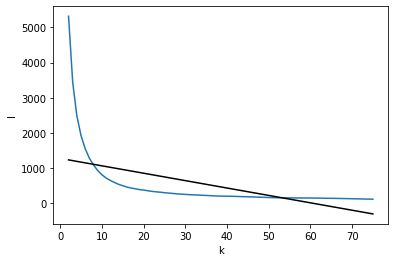

In [182]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

#KARNATAKA

In [183]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = karna_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 75
Max. k value: 14
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75] [6921.40666667 3984.87703704 2792.64864865 2074.67770115 1594.9162963
 1329.04089963 1135.02864583  981.81001372  873.16255238  785.01123119
  710.61745932  656.16425704  612.62905734  572.78504033  537.91379123
  509.71280277  484.36921909  455.67708746  433.58995238  411.46668312
  392.30360631  376.26923098  361.00842978  347.3051648   334.76149294
  323.13070162  312.74076166  301.30421091  291.16725926  281.17610464
  273.37123617  265.8717014   259.28412715  253.02756074  246.23358196
  239.45734047  233.52400739  228.14306827  223.46533333  218.39538022
  213.16956412  208.59414475  203.6629414   199.35283036  195.51921865
  191.39387868  186.86952643  182.22950188  178.32295467  173.78860318
  169

In [184]:
hfd(data_list)

1.060731949937118

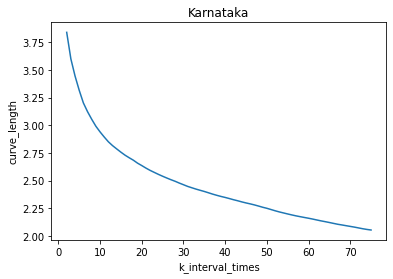

In [185]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Karnataka") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

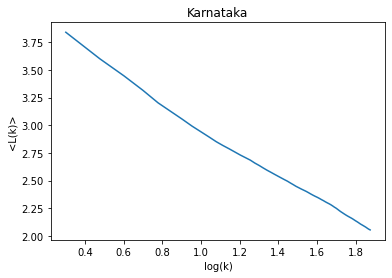

In [186]:
import math
#x = k_interval_times
log_x = []
for i in k_interval_times:
  log_x.append(math.log10(i))
  #log_x.append(int(i))
x = log_x
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
  #log_y.append(int(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Karnataka") 
plt.xlabel("log(k)") 
plt.ylabel("<L(k)>") 
plt.plot(x,y) 
plt.show()

In [187]:
plt.savefig('karna1.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([ 4.03879911 -1.06073195])
[array([0.0418653]), 2, array([1.40423584, 0.1676953 ]), 1.6431300764452317e-14]
Fit: A = -1.061[P] + 4.039 (rms residual = 0.0238)


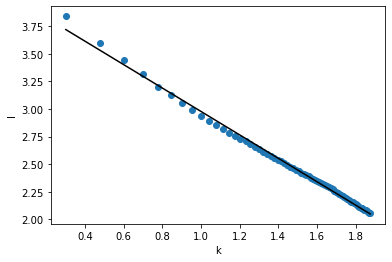

In [188]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
#conc = k_interval_times

conc = log_x #np.array(log_x, dtype=np.int)
#A = curve_length_list



A = log_y #np.array(log_y, dtype=np.int)
#np.array(data, dtype=np.float32)
#int_array = float_array.astype(int)


cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

#res = [element * pfit for element in conc]
pylab.scatter(conc, A)
pylab.plot(conc, pfit(np.array(conc, dtype=np.float32)), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

In [189]:
plt.savefig('karna2.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([1478.46623701  -24.76205577])
[array([48260635.07671181]), 2, array([1.36910029, 0.35435068]), 1.6431300764452317e-14]
Fit: A = -24.762[P] + 1478.466 (rms residual = 807.5709)


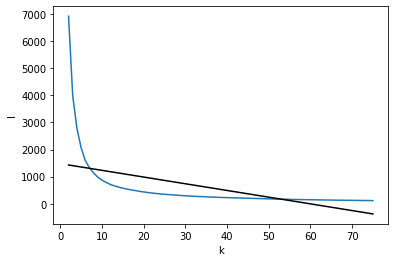

In [190]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

#UTTAR PRADESH

In [191]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = up_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 75
Max. k value: 14
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75] [3595.00333333 2187.44888889 1571.8597973  1216.7323954   993.29771605
  834.2907122   717.84114583  629.84087791  562.42026667  507.23327361
  463.76872896  426.85539786  394.90702948  368.39395556  344.25490994
  323.84306941  306.46110131  291.8199446   277.62347619  265.50741718
  254.52196344  244.78158955  235.2943287   226.83231573  218.65609923
  211.56789107  203.98411079  196.91631473  190.60011852  184.96199076
  179.86334229  175.25517804  170.58781125  165.44394947  160.74362711
  156.21938812  151.91574331  147.43334626  143.495125    139.76320715
  136.05895692  132.6062527   129.34798397  126.14234659  122.83163475
  119.54611213  116.6526331   113.85949732  111.21819733  108.48696203
  10

In [192]:
hfd(data_list)

1.0553906811543339

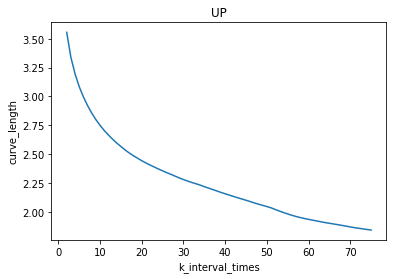

In [193]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("UP") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

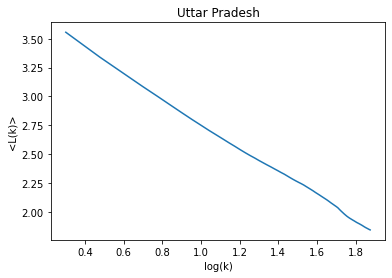

In [194]:
import math
#x = k_interval_times
log_x = []
for i in k_interval_times:
  log_x.append(math.log10(i))
  #log_x.append(int(i))
x = log_x
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
  #log_y.append(int(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Uttar Pradesh") 
plt.xlabel("log(k)") 
plt.ylabel("<L(k)>") 
plt.plot(x,y) 
plt.show()

In [195]:
plt.savefig('up1.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([ 3.82674021 -1.05539068])
[array([0.01800765]), 2, array([1.40423584, 0.1676953 ]), 1.6431300764452317e-14]
Fit: A = -1.055[P] + 3.827 (rms residual = 0.0156)


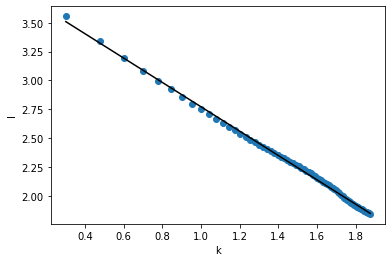

In [196]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
#conc = k_interval_times

conc = log_x #np.array(log_x, dtype=np.int)
#A = curve_length_list



A = log_y #np.array(log_y, dtype=np.int)
#np.array(data, dtype=np.float32)
#int_array = float_array.astype(int)


cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

#res = [element * pfit for element in conc]
pylab.scatter(conc, A)
pylab.plot(conc, pfit(np.array(conc, dtype=np.float32)), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

In [197]:
plt.savefig('up2.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([865.31299456 -14.31401297])
[array([12890555.03535963]), 2, array([1.36910029, 0.35435068]), 1.6431300764452317e-14]
Fit: A = -14.314[P] + 865.313 (rms residual = 417.3688)


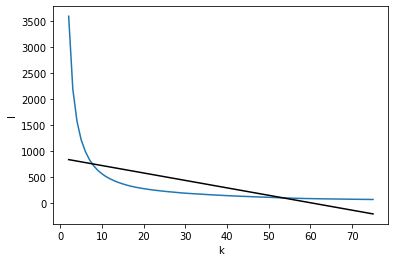

In [198]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

# DELHI

In [199]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = delhi_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 75
Max. k value: 14
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75] [4453.88       2714.38222222 1919.5777027  1475.60621609 1185.36074074
  982.811995    842.72309028  733.63717421  645.99493333  574.98526267
  517.96657548  462.88141681  424.14130224  390.90346667  356.91848416
  333.00081417  312.31087106  290.62287297  270.34330952  255.2157383
  243.08627598  232.19675077  221.76159336  210.58525867  199.5056213
  190.86259208  183.52379738  176.46558694  169.05974815  161.84854486
  155.84391276  149.35613249  143.9898738   138.20034985  132.23032407
  126.89772899  121.62834718  117.69436437  115.03708333  112.47550094
  109.88822301  106.90776913  103.63457926  100.20323731   96.50954768
   92.87514327   89.00179639   85.20039553   81.67669333   78.16740168
   75.

In [200]:
hfd(data_list)

1.3398115362443392

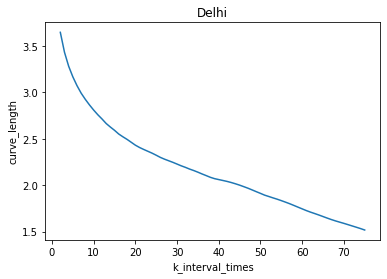

In [201]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Delhi") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

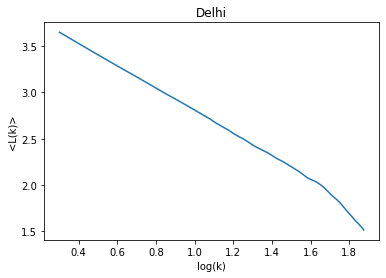

In [202]:
import math
#x = k_interval_times
log_x = []
for i in k_interval_times:
  log_x.append(math.log10(i))
  #log_x.append(int(i))
x = log_x
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
  #log_y.append(int(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Delhi") 
plt.xlabel("log(k)") 
plt.ylabel("<L(k)>") 
plt.plot(x,y) 
plt.show()

In [203]:
plt.savefig('delhi1.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([ 4.1547682  -1.33981154])
[array([0.21704168]), 2, array([1.40423584, 0.1676953 ]), 1.6431300764452317e-14]
Fit: A = -1.340[P] + 4.155 (rms residual = 0.0542)


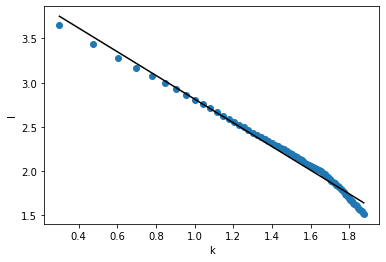

In [204]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
#conc = k_interval_times

conc = log_x #np.array(log_x, dtype=np.int)
#A = curve_length_list



A = log_y #np.array(log_y, dtype=np.int)
#np.array(data, dtype=np.float32)
#int_array = float_array.astype(int)


cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

#res = [element * pfit for element in conc]
pylab.scatter(conc, A)
pylab.plot(conc, pfit(np.array(conc, dtype=np.float32)), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

In [205]:
plt.savefig('delhi2.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([1016.16627151  -17.75545113])
[array([20712522.56963192]), 2, array([1.36910029, 0.35435068]), 1.6431300764452317e-14]
Fit: A = -17.755[P] + 1016.166 (rms residual = 529.0548)


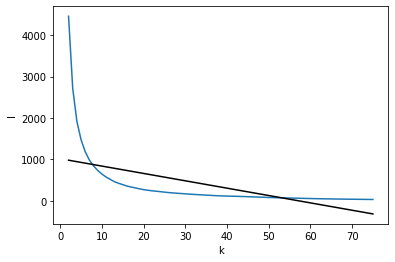

In [206]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

#WEST BENGAL

In [208]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = wb_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 75
Max. k value: 14
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75] [2152.70666667 1364.17185185  986.94932432  770.72875402  628.74518519
  529.44978481  457.69444444  402.16666667  357.81885714  322.79905219
  293.84227694  269.61933215  249.17635245  231.89770535  217.80471463
  204.386322    194.32135509  183.66838148  175.99564286  168.43909688
  160.89854746  155.24688091  149.6458912   143.49837653  138.52530724
  134.53502007  130.48963192  126.40013121  121.84573333  117.72248889
  114.73754883  111.6856907   108.70438971  105.80440816  103.01901863
  100.04448568   97.06048015   94.94266592   93.12533333   91.52912272
   90.12228701   88.74648354   87.26325758   85.66044444   83.98160324
   82.20895177   80.37340856   78.42353668   76.39621333   74.21130636
   7

In [209]:
hfd(data_list)

1.0024922751179584

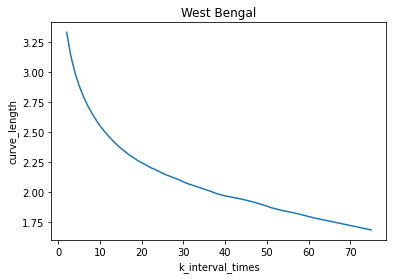

In [210]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("West Bengal") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

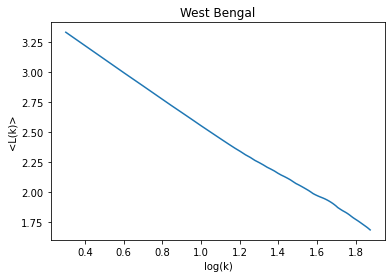

In [211]:
import math
#x = k_interval_times
log_x = []
for i in k_interval_times:
  log_x.append(math.log10(i))
  #log_x.append(int(i))
x = log_x
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
  #log_y.append(int(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("West Bengal") 
plt.xlabel("log(k)") 
plt.ylabel("<L(k)>") 
plt.plot(x,y) 
plt.show()

In [212]:
plt.savefig('wb1.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([ 3.57196639 -1.00249228])
[array([0.01868148]), 2, array([1.40423584, 0.1676953 ]), 1.6431300764452317e-14]
Fit: A = -1.002[P] + 3.572 (rms residual = 0.0159)


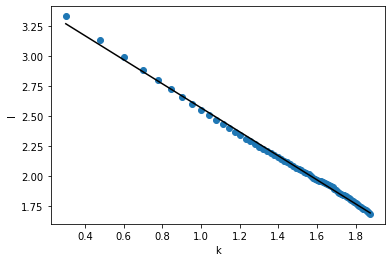

In [213]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
#conc = k_interval_times

conc = log_x #np.array(log_x, dtype=np.int)
#A = curve_length_list



A = log_y #np.array(log_y, dtype=np.int)
#np.array(data, dtype=np.float32)
#int_array = float_array.astype(int)


cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

#res = [element * pfit for element in conc]
pylab.scatter(conc, A)
pylab.plot(conc, pfit(np.array(conc, dtype=np.float32)), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

In [214]:
plt.savefig('wb2.png')

<Figure size 432x288 with 0 Axes>

Raw fit results:
poly([538.22513803  -8.77919532])
[array([4719971.28617701]), 2, array([1.36910029, 0.35435068]), 1.6431300764452317e-14]
Fit: A = -8.779[P] + 538.225 (rms residual = 252.5537)


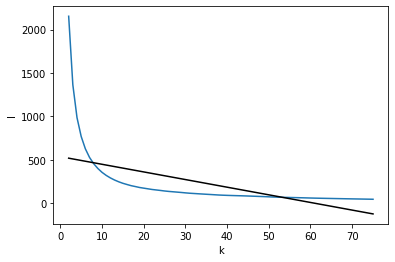

In [215]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

#Analysis